## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Solution Pipeline:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [65]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import swifter
import en_core_web_sm
nlp = en_core_web_sm.load()

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ConfusionMatrix

from sklearn import metrics
#from yellowbrick.classifier import ROCAUC



pd.set_option('display.max_columns', 500)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') 

# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

print("Number of rows in raw data: ",df.shape[0])
print("Number of columns in raw data: ",df.shape[1])
df.head()

Number of rows in raw data:  78313
Number of columns in raw data:  22


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names

df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names

df.columns = df.columns.str.replace('_', '', 1)
df.columns = df.columns.str.replace('source.', '')

In [7]:
# Lets check the changes made to the column names

print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [9]:
#Remove all rows where complaints column is NaN

df = df[df['complaint_what_happened'].notna()]
df = df.reset_index(drop = True)

In [10]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.


model = spacy.load('en_core_web_sm',disable=['parser','ner'])

def clean_text(col):
    # 1. Converting the text to lowercase
    df[col] = df[col].apply(lambda c : c.lower())     
    
    # 2. Removing text which is present in square brackets using the regex
    df[col] = df[col].apply(lambda c : re.sub('\[(.*?)\]', "", c))
    
    # 3. Removing all the punctuations from the text using the regex
    punct = "[" + re.escape(string.punctuation) + "]"
    df[col] = df[col].apply(lambda c : re.sub(punct, "", c))
    
    # 4. Removing words which contains digits/numbers
    df[col] = df[col].apply(lambda c : re.sub('\S*\d+\S*', "", c))
    
    

In [12]:
#Write your function to Lemmatize the texts

#Initializing WordNet Lemmatizer explicitly
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):      
    tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(tokens)

In [13]:
# Lets apply the clean_text function to complaint_what_happened column

clean_text('complaint_what_happened')

#Examining one row to check the cleanups done by the function 
df['complaint_what_happened'][1]

'i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [14]:
# Now, Lets apply the lemmatize_text function

df['lem_complaint'] = df['complaint_what_happened'].swifter.apply(lambda x : lemmatize_text(x))

#Examining the same row to check the lemmatization done by the function 
df['lem_complaint'][1]

'upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled'

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame(data={'Complaints': df['complaint_what_happened'], 'lemmatized_complaints': df['lem_complaint'] })
df_clean.head()

,Complaints,lemmatized_complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [16]:
#Write your function to extract the POS tags 


def extract_POS(sentence):
    words = []
    doc = model(sentence)
    
    for token in doc:
        if token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
            words.append(token.text)
            
    sent = " ".join(words)        
    return sent

In [17]:
#Creating new column Complaint_POS by applying the above created function on complaint_what_happened column

df_clean['complaint_POS'] = df_clean['Complaints'].swifter.apply(lambda x : extract_POS(x))
df_clean['complaint_POS'][1]

'xxxx xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent'

In [18]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing 
#POS tags.

df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [19]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length']  = df_clean['Complaints'].str.len()

df_clean['complaint_length'].iplot(
    kind='hist',
    bins=200,
    xTitle='Complaint length',
    linecolor='black',
    yTitle='count',
    title='Complaint Text Length Distribution')

In [20]:
df_clean.head(10)

,Complaints,lemmatized_complaints,complaint_POS,complaint_length
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,337
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456
5,can you please remove inquiry,please remove inquiry,inquiry,29
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,2224
7,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...,1350
8,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using chase ...,xxxx payment retailer chase pay xxxx chase web...,3461
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,127


#### Find the top 40 words by frequency among all the articles after processing the text.

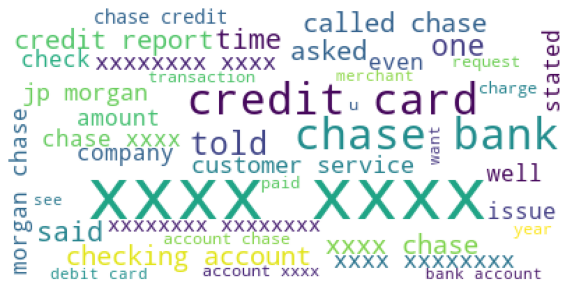

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

all_complaints = ' '.join(df_clean['lemmatized_complaints'].str.lower())

wordcloud = WordCloud(background_color="white", max_words=40).generate(all_complaints)
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [22]:
#Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
complaints = ''.join(str(df_clean['lemmatized_complaints'].tolist()))

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 


# Using the CountVectorizer function to get the unigram words
def get_unigrams(docs, n):
    vector = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # Using Bag-Of-Words model to clculate the frequency of each unigram
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

unigrams = get_unigrams(df_clean['complaint_POS'], 30)

In [25]:
#Print the top 10 words in the unigram frequency

unigrams_df = pd.DataFrame(unigrams, columns=['Word', 'Count'])
unigrams_df.head(10)

,Word,Count
0,xxxx,188217
1,chase,74129
2,account,41213
3,credit,32225
4,xxxxxxxx,27869
5,card,26805
6,bank,26408
7,payment,13963
8,time,11967
9,money,11941


In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_bigrams(docs, n):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # Again using Bag-Of-Words model to clculate the frequency of each bigrams
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of bigram words and frequency by calling the above func
bigrams = get_bigrams(df_clean['complaint_POS'], 30)

In [27]:
#Print the top 10 words in the bigram frequency

bigrams_df = pd.DataFrame(bigrams, columns=['word', 'count'])
bigrams_df.head(10)

,word,count
0,xxxx xxxx,89257
1,chase bank,12110
2,credit card,10961
3,xxxx chase,6644
4,chase xxxx,4411
5,xxxxxxxx xxxx,4286
6,account xxxx,3824
7,xxxx xxxxxxxx,3630
8,account chase,3442
9,chase credit,3398


In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_trigrams(docs, n):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # Again using Bag-Of-Words model to clculate the frequency of each trigrams
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of trigram words and frequency by calling the above func
trigrams = get_trigrams(df_clean['complaint_POS'], 30)

In [29]:
#Print the top 10 words in the trigram frequency

trigrams_df = pd.DataFrame(trigrams, columns=['word', 'count'])
trigrams_df.head(10)

,word,count
0,xxxx xxxx xxxx,45825
1,xxxx xxxx chase,3075
2,xxxxxxxx xxxx xxxx,2142
3,chase credit card,1996
4,chase xxxx xxxx,1735
5,xxxx xxxx xxxxxxxx,1711
6,jp morgan chase,1596
7,account xxxx xxxx,1515
8,chase bank xxxx,1338
9,xxxx xxxxxxxx xxxx,1231


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
#Removing the masked(XXXX) text

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [31]:
#All masked texts has been removed

df_clean

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,337,card agent anniversary date agent informatio...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433,ticket offer ticket rewards card information...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,650,chase card customer decade solicitations credi...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx chas xxxx xxxx visa credit ...,2067,wednesday chas visa credit card provider cl...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,2296,pay risk consumers chase bank app chase years ...
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom xx...,2009,credit yrs chase credit cards chase freedom p...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [32]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [33]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [34]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [35]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40) 

In [36]:
W = nmf_model.fit_transform(dtm) # Document-topic matrix
H = nmf_model.components_        # Topic-term matrix

type(tfidf.get_feature_names())

list

In [37]:
#Print the Top15 words for each of the topics

# We are using the same approach that has been used in course notebooks

# Getting the feature names
words = np.array(tfidf.get_feature_names())

# Creating a dataframe with featues and the topic-term matrix H
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,bank,chase,check,money,funds,branch,checking,deposit,accounts,business,number,days,checks,fraud
Topic 1,credit,report,inquiry,card,inquiries,score,cards,accounts,chase,account,debt,reporting,limit,information,bureaus
Topic 2,loan,mortgage,chase,home,modification,property,payments,foreclosure,years,bank,house,letter,rate,morgan,time
Topic 3,card,chase,charges,charge,credit,dispute,fraud,merchant,transaction,company,fee,purchase,phone,service,number
Topic 4,payment,payments,balance,month,fees,fee,statement,date,auto,time,chase,days,account,months,day


In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_df = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics) ])

In [39]:
#Lets inspect the Topic dataframe

topic_df.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,0.013888,0.014935,0.017521,0.005850,0.008681
1,0.007433,0.001489,0.000878,0.019887,0.003801
2,0.000000,0.038315,0.001566,0.028375,0.000000
3,0.020373,0.053543,0.015886,0.025098,0.000000
4,0.069583,0.000000,0.008394,0.007448,0.000000


In [40]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1)

In [41]:
df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,2
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,337,card agent anniversary date agent informatio...,3
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,1
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433,ticket offer ticket rewards card information...,1
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,0


In [42]:
#Print the first 5 Complaint for each of the Topics

first_five_complain=df_clean.groupby('Topic').head(5)
first_five_complain.sort_values('Topic')

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account chase bank xxxx code xxxx bonus xxxxxx...,403,account chase bank code bonus terms account...,0
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,2224,notice jp morgan chase account debit card tues...,0
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,50,account chase auto,0
13,to whom it may concern chase bank charged wron...,may concern chase bank charged wrongly overdra...,concern chase bank overdraft fees alert balanc...,547,concern chase bank overdraft fees alert balanc...,0
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,1
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433,ticket offer ticket rewards card information...,1
5,can you please remove inquiry,please remove inquiry,inquiry,29,inquiry,1
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,127,credit card data credit report company issue,1
11,i have reached out to xxxx several times in at...,reached xxxx several time attempt fraudulent i...,xxxx times attempt inquiry creditor inquiry re...,735,times attempt inquiry creditor inquiry report...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,2
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,337,card agent anniversary date agent informatio...,3
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,1
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433,ticket offer ticket rewards card information...,1
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,0


In [44]:
df_clean_bkp = df_clean.copy()

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0 : 'Bank Account services',
                1 : 'Credit card or prepaid card' ,
                2 : 'Mortgage/ Loan',
                3 : 'Theft/Dispute Reporting' , 
                4 : 'Others'
              }


#Replace Topics with Topic Names

df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,Mortgage/ Loan
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,337,card agent anniversary date agent informatio...,Theft/Dispute Reporting
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433,ticket offer ticket rewards card information...,Credit card or prepaid card
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,Bank Account services
...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,650,chase card customer decade solicitations credi...,Theft/Dispute Reporting
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx chas xxxx xxxx visa credit ...,2067,wednesday chas visa credit card provider cl...,Theft/Dispute Reporting
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,2296,pay risk consumers chase bank app chase years ...,Theft/Dispute Reporting
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom xx...,2009,credit yrs chase credit cards chase freedom p...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [47]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services':0,
                'Credit card or prepaid card':1 ,
                'Mortgage/ Loan':2,
                'Theft/Dispute Reporting':3 , 
                'Others':4
              }


#Replace Topics with Topic Names

df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,2
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx xxxx card agent anniversary date agent in...,337,card agent anniversary date agent informatio...,3
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,1
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx xxxx ticket offer ticket rewards card inf...,1433,ticket offer ticket rewards card information...,1
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,0
...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,650,chase card customer decade solicitations credi...,3
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx chas xxxx xxxx visa credit ...,2067,wednesday chas visa credit card provider cl...,3
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,2296,pay risk consumers chase bank app chase years ...,3
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom xx...,2009,credit yrs chase credit cards chase freedom p...,4


In [49]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data=df_clean[['Complaints','Topic']]

In [50]:
training_data.head()

,Complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,2
1,i upgraded my xxxx xxxx card in and was told ...,3
2,chase card was reported on however fraudulent...,1
3,on while trying to book a xxxx xxxx ticket ...,1
4,my grand son give me check for i deposit it i...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [51]:
# Write your code to get the Vector count

count_vect = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = count_vect.fit_transform(training_data['Complaints'])

# Write your code here to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [52]:
X.shape

(21072, 15956)

In [53]:
#Shape of the Response Variable

Y = training_data['Topic']
Y.shape

(21072,)

In [54]:
#test-train split

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.70, random_state=50)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Model building 

### 1. Logistic Regression





In [55]:
# First we are modelling a multi-label Logistic Regression algorithm

lr = LogisticRegression(multi_class='ovr', solver='liblinear')

# fitting the model on train data

lr_model = lr.fit(X_train, y_train)

# make predictions on train set 

X_train_pred1 = lr_model.predict(X_train)

# make predictions on test set 

X_test_pred1 = lr_model.predict(X_test)

In [56]:
# Model Evaluation: TRAIN DATA

print(metrics.classification_report(y_train, X_train_pred1 ))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3948
           1       0.98      0.96      0.97      2428
           2       0.99      0.97      0.98      2610
           3       0.97      0.98      0.97      4194
           4       0.99      0.92      0.95      1570

    accuracy                           0.97     14750
   macro avg       0.98      0.96      0.97     14750
weighted avg       0.97      0.97      0.97     14750



In [57]:
# Model Evaluation: TEST DATA

print(metrics.classification_report(y_test, X_test_pred1 ))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1684
           1       0.96      0.91      0.93      1025
           2       0.95      0.93      0.94      1097
           3       0.93      0.95      0.94      1874
           4       0.95      0.84      0.89       642

    accuracy                           0.93      6322
   macro avg       0.94      0.92      0.93      6322
weighted avg       0.93      0.93      0.93      6322



In [58]:
# Creating a Dataframe to record performance of all the models on train and test data

#For Train data
precision = metrics.precision_score(y_train, X_train_pred1,average='macro')
recall = metrics.recall_score(y_train, X_train_pred1,average='macro')
accuracy = metrics.accuracy_score(y_train, X_train_pred1)

#For Test data
precision_test = metrics.precision_score(y_test, X_test_pred1,average='macro')
recall_test = metrics.recall_score(y_test, X_test_pred1,average='macro')
accuracy_test = metrics.accuracy_score(y_test, X_test_pred1)

results = pd.DataFrame({'Model':['Logistic Regression'], 'Precision_train': [precision],'Recall_train': [recall], 'Accuracy_train':[accuracy], 'Precision_test':[precision_test], 'Recall_test':[recall_test], 'Accuracy_test':[accuracy_test]})
results

,Model,Precision_train,Recall_train,Accuracy_train,Precision_test,Recall_test,Accuracy_test
0,Logistic Regression,0.9752,0.964162,0.971119,0.940184,0.919703,0.933882


---
**`Inference`**: 
- From tha above we can see that we got a very good accuracy score of 97% & 93% for train and test for Logistic regression

---

### 2. Decision Tree

In [60]:
# Define decision tree 
dt = DecisionTreeClassifier(max_depth=8, random_state=40)

# fitting the model on train data
dt.fit(X_train, y_train)

# make predictions on train set 

X_train_pred2 = dt.predict(X_train)

# make predictions on test set 

X_test_pred2 = dt.predict(X_test)

In [61]:
# Model Evaluation: TRAIN DATA

print(metrics.classification_report(y_train, X_train_pred2 ))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      3948
           1       0.85      0.77      0.81      2428
           2       0.74      0.89      0.81      2610
           3       0.84      0.82      0.83      4194
           4       0.94      0.73      0.82      1570

    accuracy                           0.83     14750
   macro avg       0.84      0.82      0.82     14750
weighted avg       0.83      0.83      0.83     14750



In [62]:
# Model Evaluation: TEST DATA

print(metrics.classification_report(y_test, X_test_pred2 ))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1684
           1       0.79      0.72      0.76      1025
           2       0.69      0.88      0.78      1097
           3       0.82      0.77      0.80      1874
           4       0.86      0.64      0.73       642

    accuracy                           0.79      6322
   macro avg       0.79      0.77      0.78      6322
weighted avg       0.80      0.79      0.79      6322



In [63]:
#Updating the model performance dataframe

#For Train data
precision = metrics.precision_score(y_train, X_train_pred2,average='macro')
recall = metrics.recall_score(y_train, X_train_pred2,average='macro')
accuracy = metrics.accuracy_score(y_train, X_train_pred2)

#For Test data
precision_test = metrics.precision_score(y_test, X_test_pred2,average='macro')
recall_test = metrics.recall_score(y_test, X_test_pred2,average='macro')
accuracy_test = metrics.accuracy_score(y_test, X_test_pred2)

tempResults = pd.DataFrame({'Model':['Decision Tree'], 'Precision_train': [precision],'Recall_train': [recall], 'Accuracy_train':[accuracy], 'Precision_test':[precision_test], 'Recall_test':[recall_test], 'Accuracy_test':[accuracy_test]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Precision_train', 'Recall_train', 'Accuracy_train', 'Precision_test', 'Recall_test', 'Accuracy_test']]
results

,Model,Precision_train,Recall_train,Accuracy_train,Precision_test,Recall_test,Accuracy_test
0,Logistic Regression,0.975200,0.964162,0.971119,0.940184,0.919703,0.933882
0,Decision Tree,0.840967,0.815374,0.827051,0.794830,0.771297,0.787884


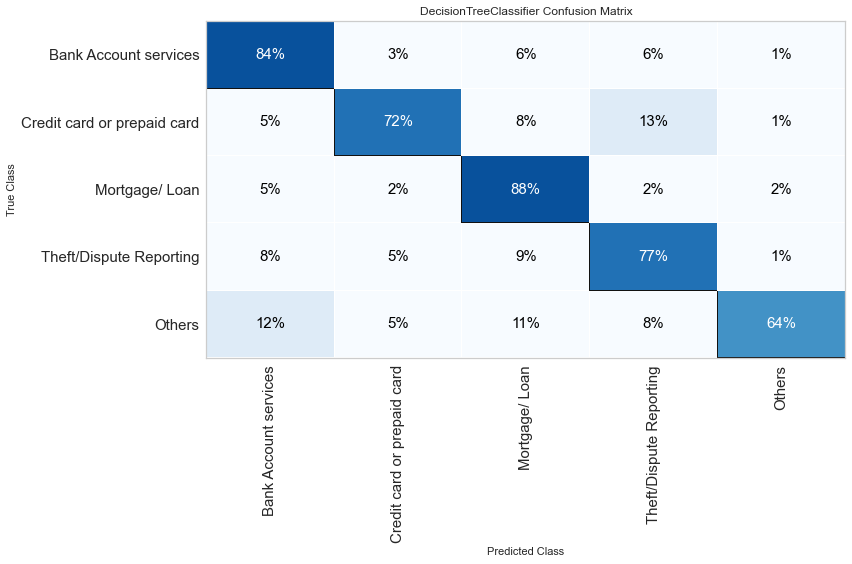

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [66]:
#visualizing the Confusion Matrix for all the 5 class labels

fig = plt.figure(figsize=(12,8))

visualizer = ConfusionMatrix(dt,
                             encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"},
                             percent=True,
                             cmap="Blues",
                             fontsize=15)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

---
**`Inference`**: 

- From the above we can see that we got decent accuracy score of 82% & 78% for train and test respectively.

---

In [67]:
# Initializing a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5,10,20],
    'max_features': [10,20,30],
    'n_estimators': [200, 500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")



In [68]:
%%time
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   22.1s finished


Wall time: 23.5 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20], 'max_features': [10, 20, 30],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [69]:
#printing the accuracy score of the best fit model

grid_search.best_score_

0.678779342557276

In [70]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, max_features=30, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [71]:
# Initialize a Random Forest Classifier

rf = RandomForestClassifier(max_depth=20, max_features=30, n_estimators=500, n_jobs=-1, random_state=42, 
                            oob_score=True)

# fitting the model on train data
rf.fit(X_train, y_train)

# make predictions on train set 

X_train_pred3 = rf.predict(X_train)

# make predictions on test set 

X_test_pred3 = rf.predict(X_test)

In [72]:
# Model Evaluation: TRAIN DATA

print(metrics.classification_report(y_train, X_train_pred3 ))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3948
           1       0.98      0.52      0.68      2428
           2       0.96      0.78      0.86      2610
           3       0.64      0.98      0.77      4194
           4       1.00      0.10      0.19      1570

    accuracy                           0.77     14750
   macro avg       0.88      0.67      0.68     14750
weighted avg       0.84      0.77      0.74     14750



In [73]:
# Model Evaluation: TEST DATA

print(metrics.classification_report(y_test, X_test_pred3 ))

              precision    recall  f1-score   support

           0       0.71      0.90      0.80      1684
           1       0.96      0.29      0.45      1025
           2       0.91      0.68      0.78      1097
           3       0.57      0.92      0.70      1874
           4       1.00      0.01      0.02       642

    accuracy                           0.68      6322
   macro avg       0.83      0.56      0.55      6322
weighted avg       0.77      0.68      0.63      6322



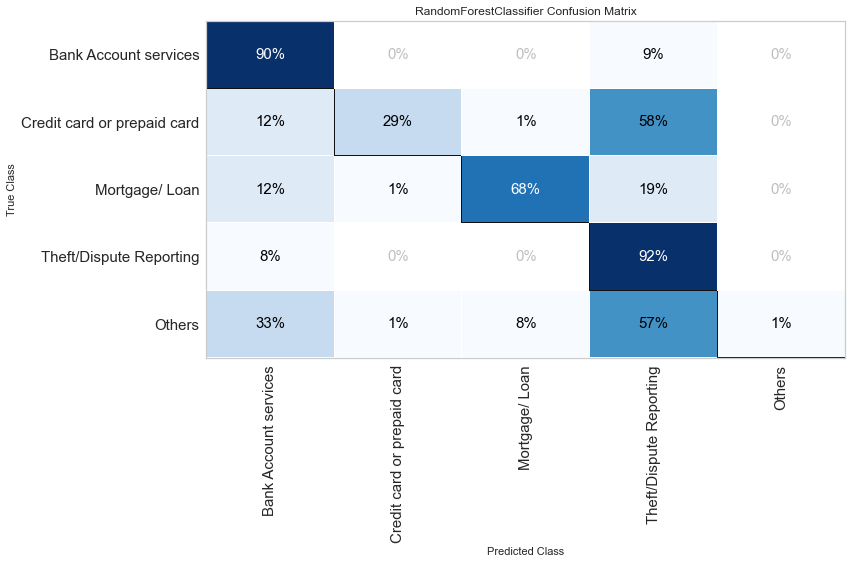

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [74]:
#visualizing the Confusion Matrix for all the 5 class labels

fig = plt.figure(figsize=(12,8))

visualizer = ConfusionMatrix(rf,
                             encoder={0:"Bank Account services", 1:"Credit card or prepaid card",2:"Mortgage/ Loan",3:"Theft/Dispute Reporting",4:"Others"},
                             percent=True,
                             cmap="Blues",
                             fontsize=15)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [75]:
#Updating the model performance dataframe

#For Train data
precision = metrics.precision_score(y_train, X_train_pred3,average='macro')
recall = metrics.recall_score(y_train, X_train_pred3,average='macro')
accuracy = metrics.accuracy_score(y_train, X_train_pred3)

#For Test Data
precision_test = metrics.precision_score(y_test, X_test_pred3,average='macro')
recall_test = metrics.recall_score(y_test, X_test_pred3,average='macro')
accuracy_test = metrics.accuracy_score(y_test, X_test_pred3)

tempResults = pd.DataFrame({'Model':['Random Forest'], 'Precision_train': [precision],'Recall_train': [recall], 'Accuracy_train':[accuracy], 'Precision_test':[precision_test], 'Recall_test':[recall_test], 'Accuracy_test':[accuracy_test]})
results = pd.concat([results, tempResults])
results = results[['Model', 'Precision_train', 'Recall_train', 'Accuracy_train', 'Precision_test', 'Recall_test', 'Accuracy_test']]
results

,Model,Precision_train,Recall_train,Accuracy_train,Precision_test,Recall_test,Accuracy_test
0,Logistic Regression,0.975200,0.964162,0.971119,0.940184,0.919703,0.933882
0,Decision Tree,0.840967,0.815374,0.827051,0.794830,0.771297,0.787884
0,Random Forest,0.878640,0.671354,0.774169,0.829618,0.561457,0.679848


---
**`Inference`**: 
- From the above we can see that for Random forest we are getting accuracy score of 77% & 68% for train and test respectively

- Also comparing all the models we got better results with the Logistic Regression, So we will use Logistic regression model..

---

In [76]:
# Custom text to predict the Topic
custom_text = 'I am really sorry to say that, I have experienced the worst banking work on your hdfc bank.'

In [77]:
# Only transform using the existing count_vect
custom_txt_X = count_vect.transform([custom_text])

In [78]:
# Only transform using the existing tfidf_transformer
custom_txt_tfidf = tfidf_transformer.transform(custom_txt_X)

In [79]:
# Predict the topic using logistic regression
y_custom_text_topic_pred = lr_model.predict(custom_txt_tfidf)

In [80]:
print(y_custom_text_topic_pred)

[0]


---
**`Inference`**: 

- The model has predicted 0 which is `Bank Account services`

---
